In [18]:
import pandas as pd

data = pd.read_pickle('result_addinfo.pickle')

In [19]:
result = data

In [20]:
result["rank"] = result["着順"].map(lambda x: x if x<4 else 4)
result.drop(["着順"],axis=1,inplace=True)

In [21]:
result["rank"].value_counts()

4    33869
1     3128
3     3125
2     3117
Name: rank, dtype: int64

In [22]:
result.drop(["馬名"], axis=1, inplace=True)
result_d = pd.get_dummies(result)

In [31]:
result_d["rank"] = result_d["rank"].map(lambda x: 1 if x<4 else 0)

In [32]:
result_d["rank"].value_counts()

0    33869
1     9370
Name: rank, dtype: int64

In [25]:
def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()
    train_id_list = sorted_id_list[:round(len(sorted_id_list)*(1-test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list)*(1-test_size)):]
    train =df.loc[train_id_list]
    test = df.loc[test_id_list]
    train.drop(['date'],axis=1,inplace=True)
    test.drop(['date'],axis=1,inplace=True)
    return train, test

In [33]:
train, test = split_data(result_d)

In [34]:
X_train = train.drop(['rank'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank'], axis=1)
y_test = test['rank']

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [41]:
y_pred = rf.predict_proba(X_test)[:,1]

In [42]:
y_pred #[0になる確率, 1になる確率]

array([0.21, 0.72, 0.29, ..., 0.02, 0.35, 0.32])

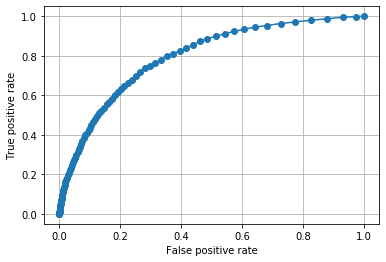

In [46]:
#モデルの精度はどのように評価するか

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
# from jupiterthemes import jtplot
# jtplot.style(theme='monokai')

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('False positive rate') #1以外のデータのうち1と予測したものの割合
plt.ylabel('True positive rate')　#実際に1のデータのうち1と予測したものの割合
plt.grid()
plt.show()
# テストデータの場合直角なほど良いモデル（aucとはこの曲線とx軸できた部分の面積を表す）

In [47]:
roc_auc_score(y_test, y_pred)

0.7959811959387971

In [48]:
y_pred_train = rf.predict_proba(X_train)[:,1]
roc_auc_score(y_train, y_pred_train) #過学習

1.0

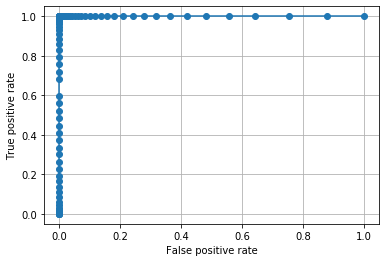

In [50]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('False positive rate') #1以外のデータのうち1と予測したものの割合
plt.ylabel('True positive rate') #実際に1のデータのうち1と予測したものの割合
plt.grid()
plt.show()

In [62]:
#過学習を抑えるためにパラメータ設定
params= {
    'min_samples_split':500,
    'max_depth':10,
#     'n_estimators':70,
    'criterion':'entropy',
    'class_weight':'balanced', #不均衡データ調整
    'random_state':100
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred_train = rf.predict_proba(X_train)[:,1]
print(roc_auc_score(y_train, y_pred_train))
y_pred_test = rf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, y_pred_test))

0.807731992011073
0.8040534583190123


In [65]:
importances = pd.DataFrame({'features': X_train.columns, 'importance': rf.feature_importances_})

In [70]:
importances.sort_values('importance', ascending=False)[:20]

,features,importance
3,単勝,0.409855
4,人気,0.371505
83,騎手_川田将雅,0.029780
14,騎手_ルメール,0.029272
6,体重,0.022168
139,騎手_福永祐一,0.013983
2,斤量,0.009188
5,齢,0.006499
115,騎手_武豊,0.005371
15,騎手_レーン,0.004445


In [69]:
#単勝オッズが良いほど、人気が高いほど3着以内確率が高いという至極当たり前な結果。

,枠番,馬番,斤量,騎手,単勝,人気,性,齢,体重,体重増減,course_len,weather,race_type,ground_state,date,rank
202001010101,6,6,54.0,横山武史,16.0,3.0,牝,2,438,4,1800,曇,芝,良,2020-07-25,1
202001010101,2,2,54.0,ルメール,1.9,2.0,牡,2,510,0,1800,曇,芝,良,2020-07-25,1
202001010101,3,3,54.0,池添謙一,1.8,1.0,牡,2,482,-6,1800,曇,芝,良,2020-07-25,1
202001010101,1,1,52.0,亀田温心,22.2,4.0,牝,2,442,0,1800,曇,芝,良,2020-07-25,0
202001010101,4,4,54.0,藤岡康太,55.7,5.0,牡,2,426,-8,1800,曇,芝,良,2020-07-25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202010020812,1,1,57.0,武豊,6.5,4.0,牡,4,476,-2,1700,雨,ダート,重,2020-09-06,0
202010020812,8,14,57.0,浜中俊,19.8,8.0,牡,4,522,-8,1700,雨,ダート,重,2020-09-06,0
202010020812,8,15,57.0,国分恭介,75.0,14.0,牡,5,510,0,1700,雨,ダート,重,2020-09-06,0
202010020812,2,3,55.0,太宰啓介,46.1,10.0,牝,4,488,-12,1700,雨,ダート,重,2020-09-06,0


In [88]:
#勾配ブースティング木
import lightgbm as lgb

params = {
    'num_leaves':3, #デフォルトは34
    'n_estimators':70,
    'min_data_in_leaf':300,
#     'class_weight':'balanced',
    'random_state':100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values) #値に日本語が入っているとエラー

y_pred_train = lgb_clf.predict_proba(X_train)[:,1]
print(roc_auc_score(y_train, y_pred_train))
y_pred = lgb_clf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
0.805986543604988
0.8111897683838226


In [89]:
importances = pd.DataFrame({'features': X_train.columns, 'importance': rf.feature_importances_})
importances.sort_values('importance', ascending=False)[:20]

,features,importance
3,単勝,0.409855
4,人気,0.371505
83,騎手_川田将雅,0.029780
14,騎手_ルメール,0.029272
6,体重,0.022168
139,騎手_福永祐一,0.013983
2,斤量,0.009188
5,齢,0.006499
115,騎手_武豊,0.005371
15,騎手_レーン,0.004445
